In [14]:
import plotly.io as pio
pio.templates.default = 'plotly'
pio.templates
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import geopandas as gpd
import statsmodels.api as sm
from tqdm import tqdm
import geopandas as gpd
import folium
from folium import Choropleth
from folium.features import GeoJson

In [2]:
def latlonTable2GDF(table: pd.DataFrame, colName_lat: str, colName_lon: str):
    return gpd.GeoDataFrame(table, geometry=gpd.points_from_xy(table[colName_lon], table[colName_lat])).set_crs(6668)
NTT_TIME_LIST = ['0000', '0100', '0200', '0300', '0400', '0500', '0600', '0700', '0800', '0900', '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']

In [19]:
DIR_LOGS = "Z:\\lab\\output\\logs\\"
DIR_MOBILE = "Z:\\lab\\SSI2024_検証\\モバイル空間統計_WEEKDAY\\"
seed = 20000
noOfPeople = 40000
FILE_NAME_HEAD = f"seed_{seed}_no_{noOfPeople}_"

In [4]:
# spot = pd.read_csv(DIR_LOGS + FILE_NAME_HEAD + "spot_log.csv")
location = pd.read_csv(DIR_LOGS + FILE_NAME_HEAD + "location_log.csv",dtype={"NttTime":str})

In [78]:
# spot.filter(items=["CurrentTime","CurrentDay","Person2"]).query("CurrentTime.str.contains(':00:00')", engine='python')

In [10]:
mesh_poly = gpd.read_file("Z:\\lab\\SSI2024_検証\\47207_mesh_poly\\47207_mesh_poly.shp").drop(columns=["JCODE"])

In [86]:
df_0000 = pd.read_csv(DIR_MOBILE + f"{"0000"}.csv", dtype={"KEY_CODE": str, "time": str, "population": int})
df_24 = []
for HHMM in tqdm(NTT_TIME_LIST):
    df_24.append(pd.read_csv(DIR_MOBILE + f"{HHMM}.csv", dtype={"KEY_CODE": str, "time": str, "population": int}))
df_24 = pd.concat(df_24)
df_24["time"] = df_24["time"].apply(lambda x: x[:2]+":"+x[2:])

100%|██████████| 24/24 [00:02<00:00,  8.70it/s]


In [122]:
results = []
for HHMM in tqdm(NTT_TIME_LIST):
    df = pd.read_csv(DIR_MOBILE + f"{HHMM}.csv", dtype={"KEY_CODE": str, "time": str, "population": int})

    location_count = gpd.sjoin(latlonTable2GDF(location, "Latitude", "Longitude"), mesh_poly.to_crs(6668), how="left", predicate="intersects")
    location_count = location_count.filter(items=["KEY_CODE", "NttTime", "PersonId"]).groupby(["KEY_CODE", "NttTime"], as_index=False).count()
    location_count = location_count.set_axis(["mesh_code", "ntt_time", "sim_pop"], axis=1).query("ntt_time == @HHMM")

    result = pd.merge(df, location_count, left_on="KEY_CODE", right_on="mesh_code", how="left").filter(["KEY_CODE","time", "population", "sim_pop"])
    result["sim_pop"] = result["sim_pop"].fillna(0.0)
    results.append(result)
results = pd.concat(results,axis=0)
results["time"] = results["time"].apply(lambda x: x[:2]+":"+x[:2])

100%|██████████| 24/24 [01:07<00:00,  2.83s/it]


<Axes: >

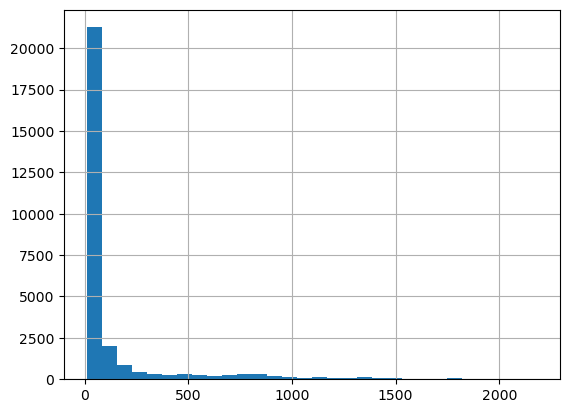

In [130]:
results.query("population != 0")["population"].hist(bins=30)

<Axes: >

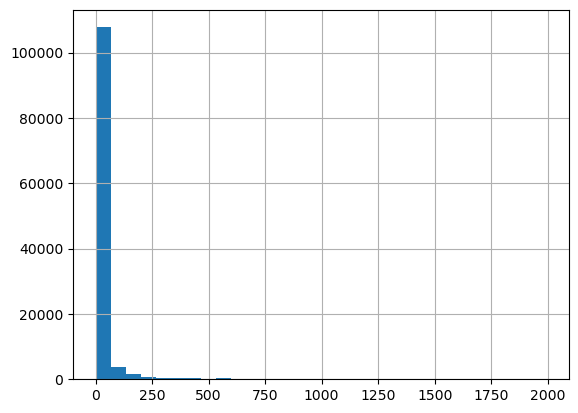

In [132]:
results.query("sim_pop < 2000")["sim_pop"].hist(bins=30)

In [144]:
results["sim_minus_pop"] = results["sim_pop"] - results["population"]
results.head()

,KEY_CODE,time,population,sim_pop,sim/pop,sim-pop,sim_minus_pop
0,362431911,00:00,0,0.0,NaN,0.0,0.0
1,362431912,00:00,0,0.0,NaN,0.0,0.0
2,362431913,00:00,0,0.0,NaN,0.0,0.0
3,362431914,00:00,0,0.0,NaN,0.0,0.0
4,362431923,00:00,13,270.0,20.769231,257.0,257.0


<Axes: >

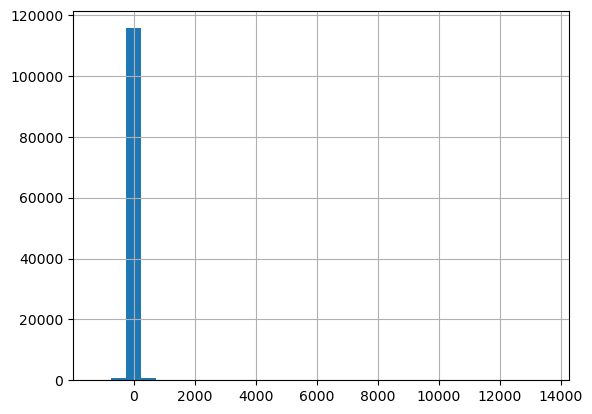

In [150]:
results["sim_minus_pop"].hist(bins=30)

In [153]:
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly'
import json

# サンプルデータ: ここでは1時間分のサンプルデータを仮定しています。
# 24時間分のデータを作るために for ループを使います。

# 元のGeoDataFrame
mesh_poly = mesh_poly.to_crs("EPSG:4326")  # 座標系をWGS84に変換


# GeoDataFrame を GeoJSON に変換
mesh_json = json.loads(mesh_poly.to_json())

custom_scale = [
    [0, 'blue'],   # 小さい値は青
    [0.5, 'white'],  # 中間値は白
    [1, 'red']  # 大きい値は赤
]
# Plotly のヒートマップの作成
fig = px.choropleth_mapbox(
    results,
    geojson=mesh_json,  # メッシュのジオメトリ
    locations="KEY_CODE",  # メッシュコード
    featureidkey="properties.KEY_CODE",  # GeoJSON 内のキー
    color="sim_minus_pop",  # 色分けする数値（人口）
    # color_continuous_scale="OrRd",  # カラースケール
    color_continuous_scale=custom_scale,
    mapbox_style="carto-positron",  # Mapbox のスタイル
    zoom=11,  # ズームレベル
    center={"lat": 24.325, "lon": 124.145},  # 中心点の座標
    opacity=0.3,  # ポリゴンの透明度
    labels={"sim_minus_pop": "Simulated_Minus_Mobile"},  # ラベルのカスタマイズ
    animation_frame="time",  # 時間ごとにアニメーション化
    range_color=[-750, 750]  # カラースケールの範囲を設定
    # range_color=[0, df_24['population'].max()]  # カラースケールの範囲を設定
)

# Mapbox のトークンを設定
fig.update_layout(mapbox_accesstoken="pk.eyJ1IjoidG9yYWppOTkwMDk5IiwiYSI6ImNscDNmNWFheTB4NncyaW1yYndtczQzbjkifQ.X6SGmlD0jbEelzgu2yRbUA")

# タイトルやレイアウトの設定
fig.update_layout(title="Population Heatmap by Time", margin={"r":0,"t":0,"l":0,"b":0})

# 結果を保存
output_path = f"Z:\\lab\\SSI2024_検証\\chart\\Choropleth\\seed_{seed}-no_{noOfPeople}-Simulated_Minus_Mobile_w.html"
fig.write_html(output_path)

# グラフの表示
# fig.show()


C:\Users\tora2\anaconda3\envs\geo_env\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [ ]:
# plotlyでchoropleth
import plotly.express as px

import json

# 座標系を WGS84 (EPSG:4326) に変換
gdf = gdf.to_crs("EPSG:4326")

# GeoDataFrame を GeoJSON に変換
gdf_json = json.loads(gdf.to_json())

# Plotly のヒートマップの作成
# Plotly のヒートマップの作成（アニメーションを追加）
fig = px.choropleth_mapbox(
    gdf,
    geojson=gdf_json,  # メッシュのジオメトリ
    locations="KEY_CODE",  # メッシュコード
    featureidkey="properties.KEY_CODE",  # GeoJSON 内のキー
    color="population",  # 色分けする数値（人口）
    color_continuous_scale="OrRd",  # カラースケール
    mapbox_style="carto-positron",  # Mapbox のスタイル
    zoom=11,  # ズームレベル
    center={"lat": 24.325, "lon": 124.145},  # 中心点の座標
    opacity=0.3,  # ポリゴンの透明度
    labels={"population": "Population"},  # ラベルのカスタマイズ
    animation_frame="time"  # 時間ごとにアニメーション化
)

# Mapbox のトークンを設定
fig.update_layout(mapbox_accesstoken="pk.eyJ1IjoidG9yYWppOTkwMDk5IiwiYSI6ImNscDNmNWFheTB4NncyaW1yYndtczQzbjkifQ.X6SGmlD0jbEelzgu2yRbUA")

# タイトルやレイアウトの設定
fig.update_layout(title="Population Heatmap by Time", margin={"r":0,"t":0,"l":0,"b":0})

# グラフの表示
fig.write_html(f'Z:/lab/SSI2024_検証/chart/Choropleth/seed_{seed}-no_{noOfPeople}.html')
